In [13]:
import os 
import json
import sys
from collections import namedtuple
import pandas as pd

Benchmark = namedtuple('Benchmark', 'isPolling iodepth numjobs GenIOPS ActualIOPS P99_lat cpu_idleness')
NumJobs = [1]
IODepth = [1, 2, 4,6, 8]
IOPS = (100000, 200000, 300000, 400000, 500000, 600000, 700000)

entries = os.listdir("./")
json_files = [f for f in entries if f.endswith("json")]
benchmark_record = []

for file in json_files:
    with open(file) as fd:
        try:
            dd = json.load(fd)
        except:
            sys.stderr.write("error loading json %s" % file, file=sys.stdout)
            exit(1)
    sss = file.split("-")
    b1 = Benchmark(int(dd["jobs"][0]["job options"]["sqthread_poll"]), \
        int(dd["jobs"][0]["job options"]["iodepth"]), \
        int(dd["jobs"][0]["job options"]["numjobs"]), \
        int(dd["jobs"][0]["job options"]["rate_iops"]), \
        float(dd["jobs"][0]["read"]["iops_mean"]), \
        float(dd["jobs"][0]["read"]["clat_ns"]["percentile"]["99.000000"]),\
        float(dd["cpu_idleness"]["system"])

        )
    benchmark_record.append(b1)

df = pd.DataFrame(benchmark_record)
df["CPU_util"] =  100 - df["cpu_idleness"]
df["iops_per_cpuutil"] =  df["ActualIOPS"] / df["CPU_util"] 


In [14]:
df

,isPolling,iodepth,numjobs,GenIOPS,ActualIOPS,P99_lat,cpu_idleness,CPU_util,iops_per_cpuutil
0,1,1,1,500000,56204.425887,10816.0,71.571326,28.428674,1977.032973
1,1,2,1,300000,104664.244259,14784.0,71.558860,28.441140,3680.029853
2,0,2,1,300000,122066.524008,13888.0,88.860978,11.139022,10958.459729
3,1,2,1,400000,101154.897704,14784.0,71.598567,28.401433,3561.612462
4,0,6,1,600000,183581.924843,28032.0,88.766525,11.233475,16342.398487
...,...,...,...,...,...,...,...,...,...
65,1,1,1,200000,57904.388309,10816.0,71.580214,28.419786,2037.467429
66,1,4,1,200000,186519.801670,19328.0,71.754356,28.245644,6603.489079
67,0,4,1,500000,191846.498956,21120.0,85.862966,14.137034,13570.491445
68,0,8,1,700000,181651.183716,29568.0,88.548565,11.451435,15862.744164


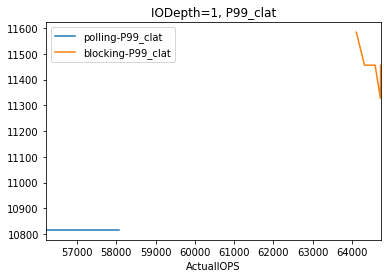

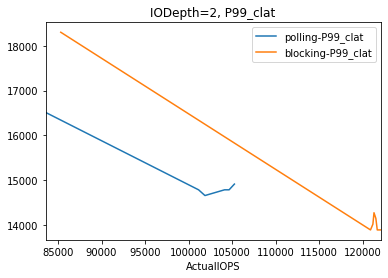

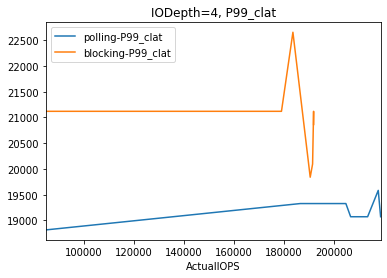

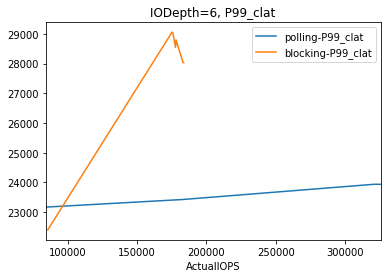

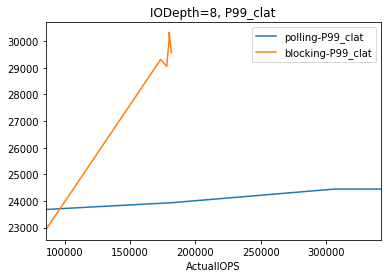

In [16]:
import matplotlib.pyplot as plt

for iod in IODepth:
#     print(iod)
    blocking=df[(df["isPolling"]==0)&(df["iodepth"]==iod)]
    blocking=blocking.sort_values(by="ActualIOPS")

    polling=df[(df["isPolling"]==1)&(df["iodepth"]==iod)]
    polling=polling.sort_values(by="ActualIOPS")
    
    ax = polling.plot.line(x="ActualIOPS",y="P99_lat",label="polling-P99_clat")
    blocking.plot.line(x="ActualIOPS",y="P99_lat",ax=ax, label="blocking-P99_clat")
    ax.set_title(label="IODepth=%d, P99_clat" % (iod))
    
#     ax.set_xlim([0,600000])
#     ax.set_ylim([10000, 30000])
    


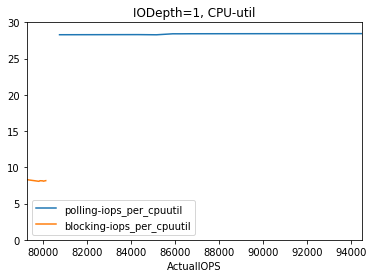

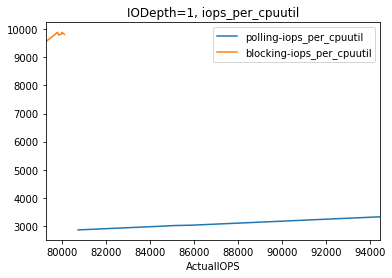

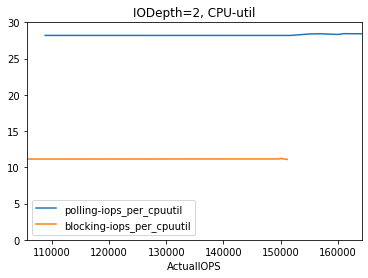

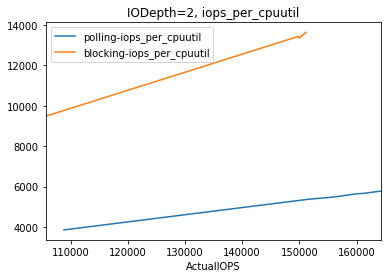

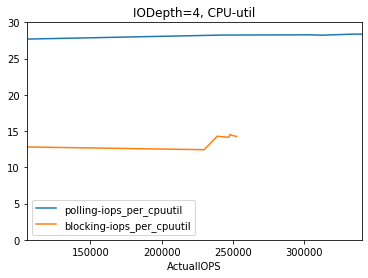

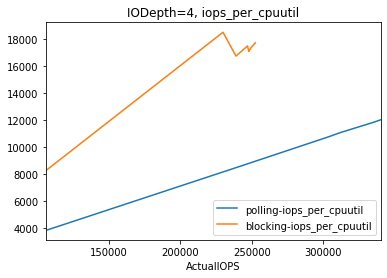

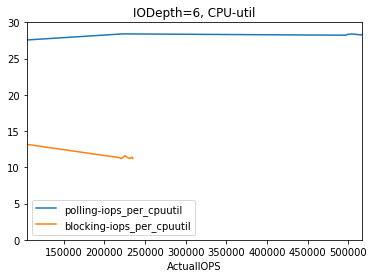

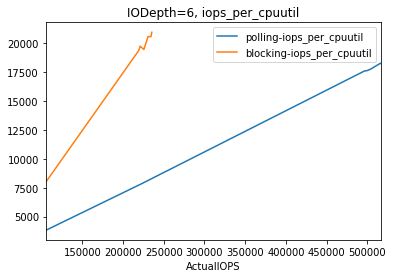

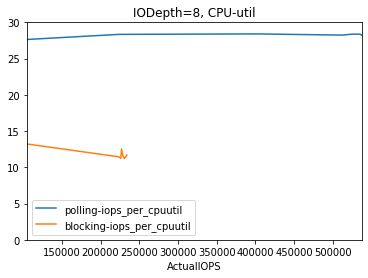

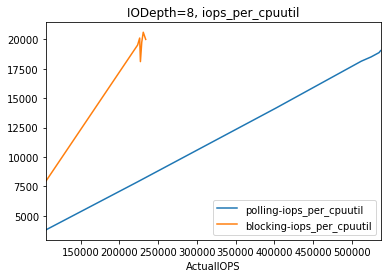

In [12]:
for iod in IODepth:
#     print(iod)
    blocking=df[(df["isPolling"]==0)&(df["iodepth"]==iod)]
    blocking=blocking.sort_values(by="ActualIOPS")

    polling=df[(df["isPolling"]==1)&(df["iodepth"]==iod)]
    polling=polling.sort_values(by="ActualIOPS")

    
    ax1 = polling.plot.line(x="ActualIOPS",y="CPU_util",label="polling-iops_per_cpuutil")
    blocking.plot.line(x="ActualIOPS",y="CPU_util",ax=ax1, label="blocking-iops_per_cpuutil")
    ax1.set_title(label="IODepth=%d, CPU-util" % (iod))
#     ax1.set_xlim([0,600000])
    ax1.set_ylim([0,30])

    ax2 = polling.plot.line(x="ActualIOPS",y="iops_per_cpuutil",label="polling-iops_per_cpuutil")
    blocking.plot.line(x="ActualIOPS",y="iops_per_cpuutil",ax=ax2, label="blocking-iops_per_cpuutil")
    ax2.set_title(label="IODepth=%d, iops_per_cpuutil" % (iod))
#     ax2.set_xlim([0,600000])
